In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
import scipy.io as sio
from functools import partial
from matplotlib.colors import ListedColormap
from sklearn import tree
from sklearn import metrics



#### SVM 

In [2]:
# Calculate error given feature vectors X and labels Y.
def calc_error_htmap(X, Y, classifier):
    Y_pred = classifier.predict(X)
    e = 1 - accuracy_score(Y, Y_pred)
    return e

###heatmap function call for the SVM Classifier###
def draw_heatmap(training_errors, gamma_list, C_list):
    plt.figure(figsize = (5,4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f', 
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel = '$\gamma$', ylabel='$C$')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Training error w.r.t $C$ and $\gamma$')
    plt.show()

In [3]:
### calls for linear SVM
# Judge function: 1(a != b). It supports scalar, vector and matrix.
def judge_1(a, b):
    return np.array(a != b).astype(np.float32)

# Judge function: 1(z > 0). It supports scalar, vector and matrix.
def judge_2(z):
    return np.array(z > 0).astype(np.float32)
    
# Rectifier function: (z)_+ = max(0, z). It supports scalar, vector and matrix.
def rectifier(z):
    return np.clip(z, a_min=0, a_max=None)

# Linear SVM classifier.
def f_linear_svm(x, W, b):
    if (np.dot(W.T,x)+b) >=0:
        return 1
    else: 
        return -1
# Calculate error given feature vectors X and labels Y.
def calc_error(X, Y, W, b):
    n=len(X)
    error=0
    e_train=0
    for (xi, yi) in zip(X, Y):
        e_train= e_train + judge_1(f_linear_svm(xi,W,b),yi)
    error= e_train/n
    
    return error 
# Gradient of L(W, b) with respect to W and b.
def grad_L_W_b(X, Y, W, b, C):
    one_vec=np.ones(len(X))
    a=one_vec-Y*(np.dot(X,W)+np.dot(b,one_vec))
    inner_fn=(judge_2(a)*Y)
    outer_fn=np.dot(C,X.T)
    outer_fn2=np.dot(C,one_vec.T)
    grad_W =W-np.dot(outer_fn,inner_fn)
    grad_b =-(np.dot(outer_fn2,inner_fn))
    return grad_W, grad_b
# loss function
def L_W_b(X, Y, W, b, C):
    one_vec=np.ones(len(X))
    a=one_vec-Y*(np.dot(X,W)+b)

    loss=((1/2)*(np.dot(W.T,W)))+np.dot(np.dot(C,one_vec.T),rectifier(a))
    return loss

    


In [4]:
#Here are the predefined condition for our SVM
# training_errors: A NumPy array with the shape (len(C_list), len(gamma_list))
# gamma_list: List of gamma(s).
# C_list: List of C(s).
C_list = [1, 10, 100, 1000, 10000]
gamma_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
opt_e_training = 1.0   # Optimal training error.
opt_classifier = None  # Optimal classifier.
opt_C          = None  # Optimal C.
opt_gamma      = None  # Optimal C.

#Here are some settings for Linear SVM
learning_rate = 0.0001
iterations    = 10000
losses = []
# Gradient descent algorithm for linear SVM classifier.
# Step 1. Initialize the parameters W, b.
W = np.zeros(2) 
b = 0
C = 1000


In [5]:
## Visualization for linear SVM
def vis(X, Y, W=None, b=None):
    indices_neg1 = (Y == -1).nonzero()[0]
    indices_pos1 = (Y == 1).nonzero()[0]
    plt.scatter(X[:,0][indices_neg1], X[:,1][indices_neg1], 
                c='blue', label='class -1')
    plt.scatter(X[:,0][indices_pos1], X[:,1][indices_pos1], 
                c='red', label='class 1')
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')
    
    if W is not None:
        # w0x0+w1x1+b=0 => x1=-w0x0/w1-b/w1
        w0 = W[0]
        w1 = W[1]
        temp = -w1*np.array([X[:,1].min(), X[:,1].max()])/w0-b/w0
        x0_min = max(temp.min(), X[:,0].min())
        x0_max = min(temp.max(), X[:,1].max())
        x0 = np.linspace(x0_min,x0_max,100)
        x1 = -w0*x0/w1-b/w1
        plt.plot(x0,x1,color='black')

    plt.show()

In [6]:
iris = datasets.load_iris()     # Load Iris dataset.

X = iris.data                   # The shape of X is (150, 4), which means
                                # there are 150 data points, each data point
                                # has 4 features.
Y = (iris.target > 1.5).reshape(-1,1).astype(np.float) # The shape of Y is (150, 1), which means 
                                # there are 150 data points, each data point
                                # has 1 target value. 
Y[Y==0] = -1

X_and_Y = np.hstack((X, Y))     # Stack them together for shuffling.
                                    # NOTE: we don't set a seed.
print(X_and_Y.shape)
np.random.shuffle(X_and_Y)      # Shuffle the data points in X_and_Y array
    # Divide the data points into training set and test set.
X_shuffled = X_and_Y[:,:4]
print(X_shuffled.shape)
Y_shuffled = X_and_Y[:,4]
print(Y_shuffled.shape)
X_train = X_shuffled[:120][:, [3,1]]     # Shape: (120,2)
print(X_train.shape)
Y_train = Y_shuffled[:120]               # Shape: (120,)
print(Y_train.shape)
X_test  = X_shuffled[120:][:, [3,1]]    # Shape: (30,2)
print(X_test.shape)
Y_test  = Y_shuffled[120:]              # Shape: (30,)
print(Y_test.shape)
print(X_shuffled)

(150, 5)
(150, 4)
(150,)
(120, 2)
(120,)
(30, 2)
(30,)
[[5.9 3.  5.1 1.8]
 [5.2 4.1 1.5 0.1]
 [6.4 3.2 5.3 2.3]
 [6.  3.4 4.5 1.6]
 [5.  3.  1.6 0.2]
 [4.9 2.5 4.5 1.7]
 [6.3 2.7 4.9 1.8]
 [5.8 4.  1.2 0.2]
 [6.8 3.  5.5 2.1]
 [6.6 2.9 4.6 1.3]
 [5.6 2.5 3.9 1.1]
 [7.7 3.8 6.7 2.2]
 [4.9 3.1 1.5 0.1]
 [5.7 2.6 3.5 1. ]
 [6.  2.2 5.  1.5]
 [6.7 3.  5.  1.7]
 [4.7 3.2 1.6 0.2]
 [6.1 2.8 4.7 1.2]
 [5.5 4.2 1.4 0.2]
 [5.1 3.8 1.9 0.4]
 [4.6 3.1 1.5 0.2]
 [5.7 3.8 1.7 0.3]
 [6.3 3.4 5.6 2.4]
 [5.6 2.8 4.9 2. ]
 [5.  3.4 1.5 0.2]
 [6.3 2.9 5.6 1.8]
 [5.3 3.7 1.5 0.2]
 [6.3 2.5 4.9 1.5]
 [5.  3.5 1.3 0.3]
 [5.  3.5 1.6 0.6]
 [5.4 3.9 1.3 0.4]
 [5.  3.3 1.4 0.2]
 [5.4 3.  4.5 1.5]
 [6.2 3.4 5.4 2.3]
 [5.  3.2 1.2 0.2]
 [7.9 3.8 6.4 2. ]
 [7.2 3.6 6.1 2.5]
 [4.4 3.2 1.3 0.2]
 [6.  2.9 4.5 1.5]
 [6.2 2.9 4.3 1.3]
 [5.2 3.4 1.4 0.2]
 [6.4 3.2 4.5 1.5]
 [6.1 2.6 5.6 1.4]
 [5.7 3.  4.2 1.2]
 [6.6 3.  4.4 1.4]
 [5.  2.  3.5 1. ]
 [6.  2.7 5.1 1.6]
 [6.9 3.1 5.1 2.3]
 [5.6 2.9 3.6 1.3]
 [5.9 3.2 4.8 

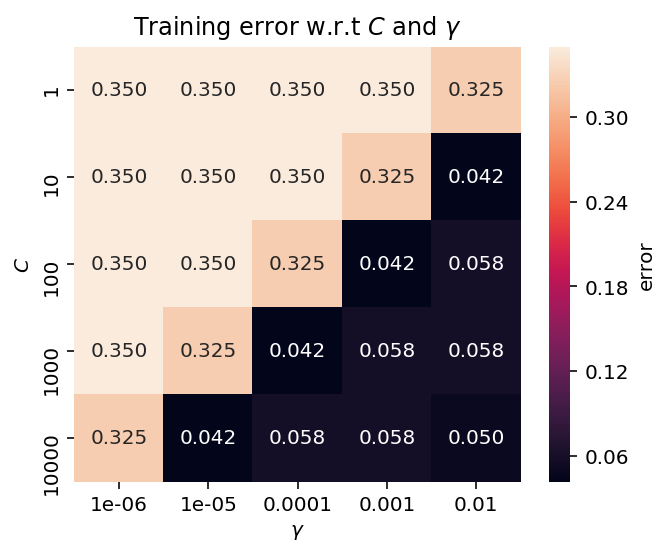

Best parameter C*=10, best parameter gamma*=0.01
Test error: 0.0
Train error: 0.050000000000000044
Decision boundary: 387.817x0+-118.156x1+-296.000=0


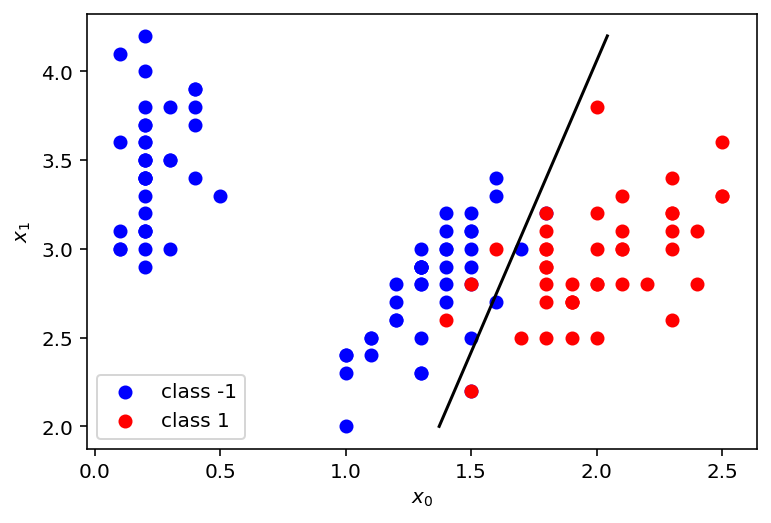

Training error: 0.058333333333333334


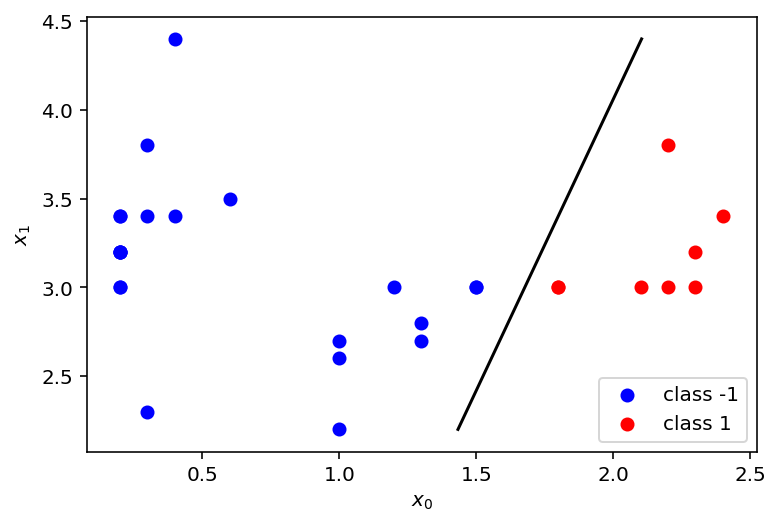

Test error: 0.0


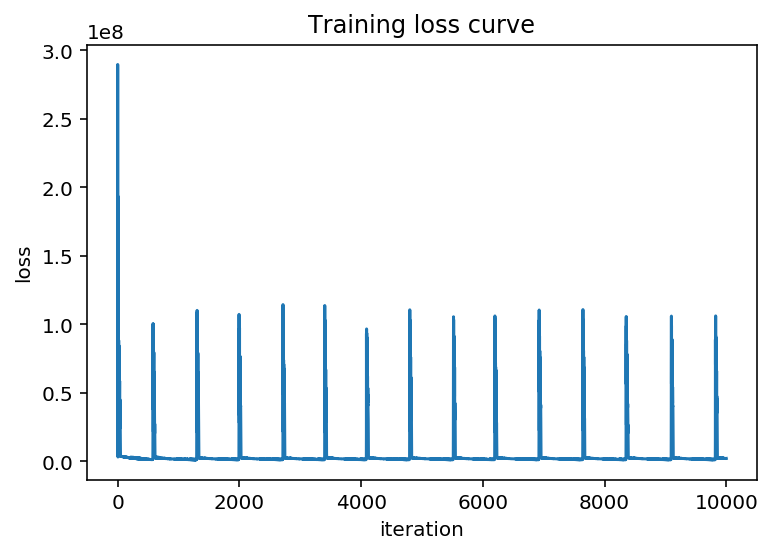

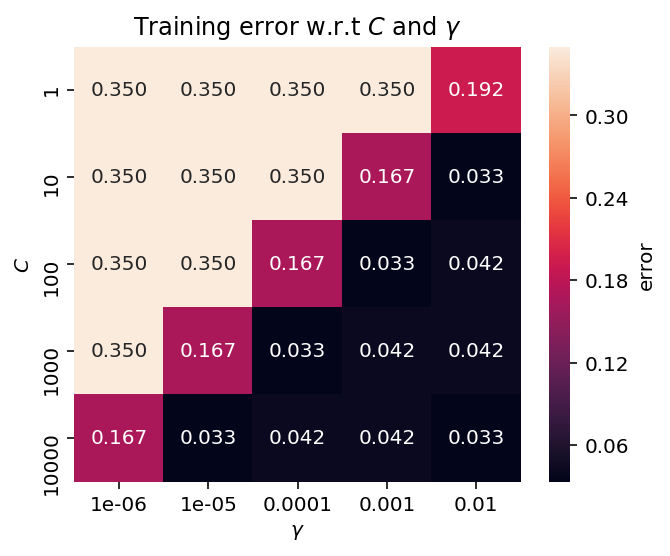

Best parameter C*=10, best parameter gamma*=0.01
Test error: 0.06666666666666665
Train error: 0.033333333333333326
Decision boundary: 309.909x0+-64.677x1+-323.000=0


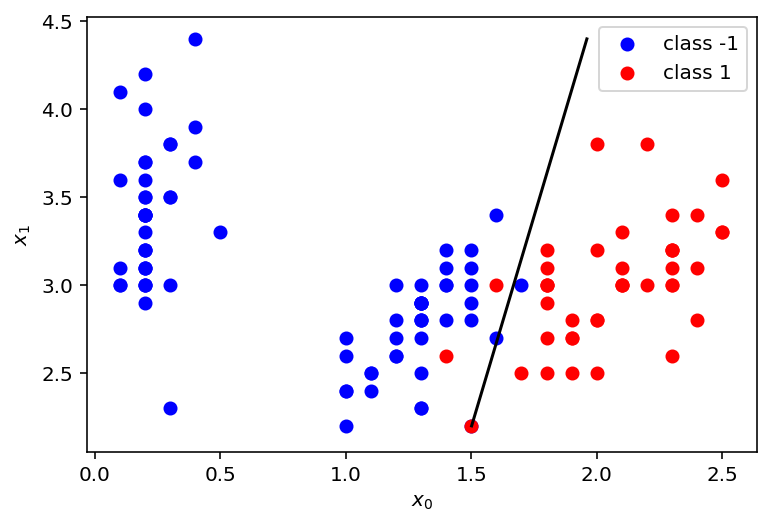

Training error: 0.03333333333333333


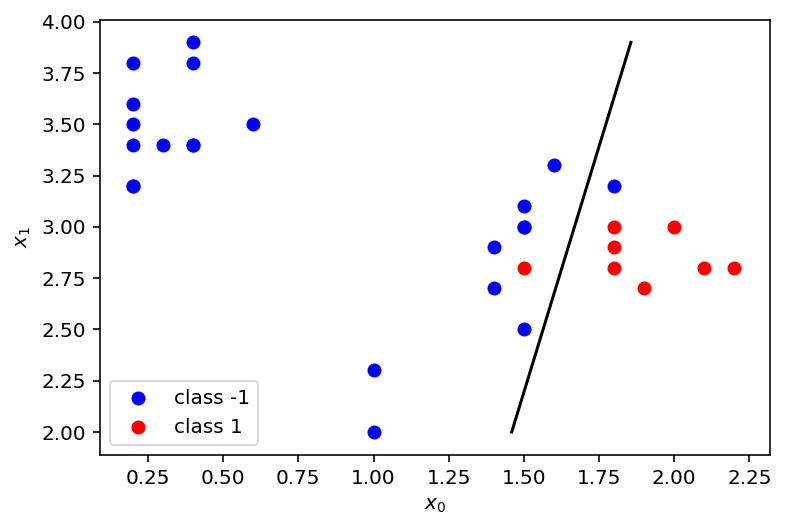

Test error: 0.06666666666666667


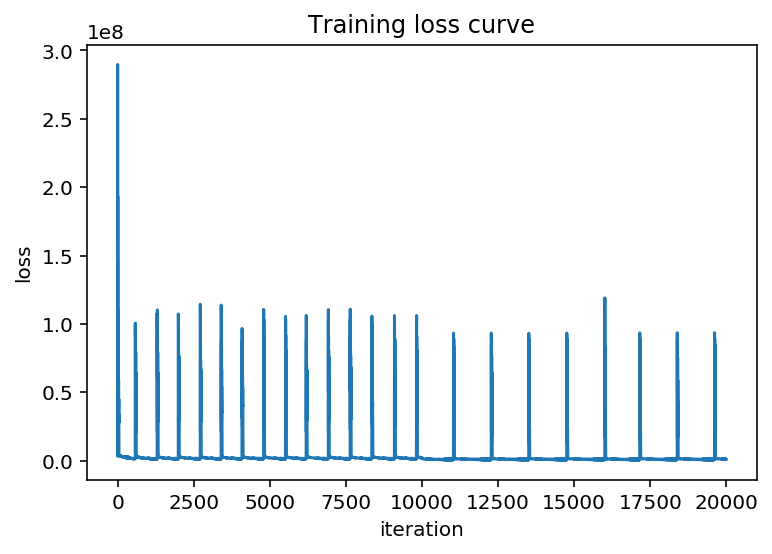

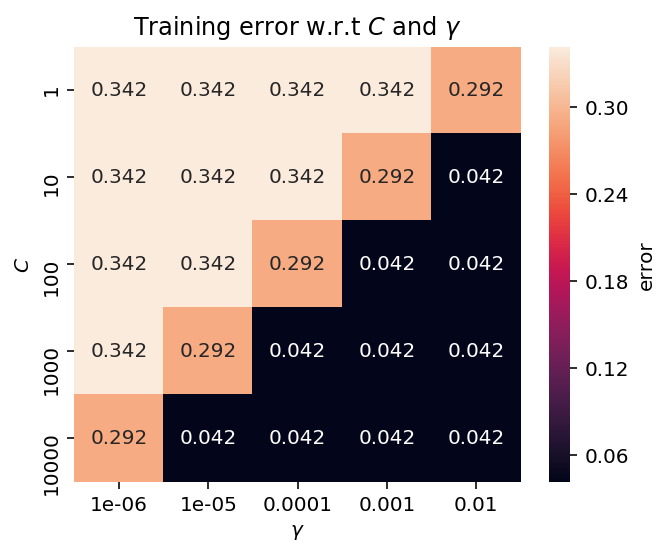

Best parameter C*=10, best parameter gamma*=0.01
Test error: 0.033333333333333326
Train error: 0.04166666666666663
Decision boundary: 249.824x0+-64.774x1+-235.000=0


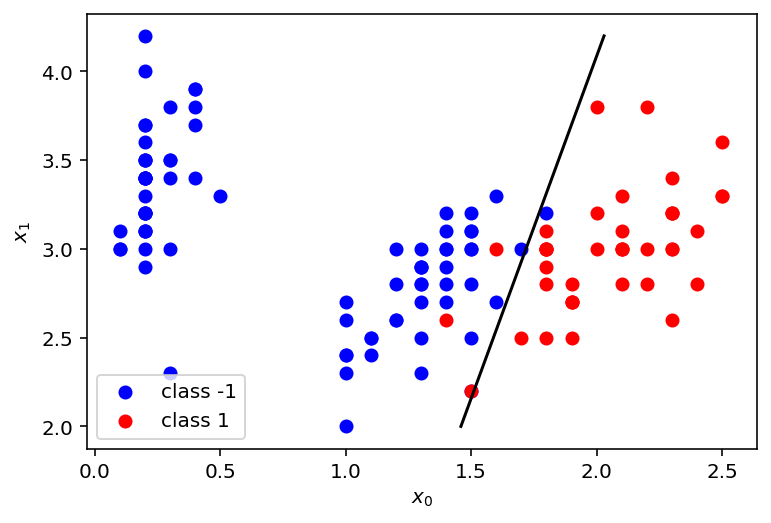

Training error: 0.03333333333333333


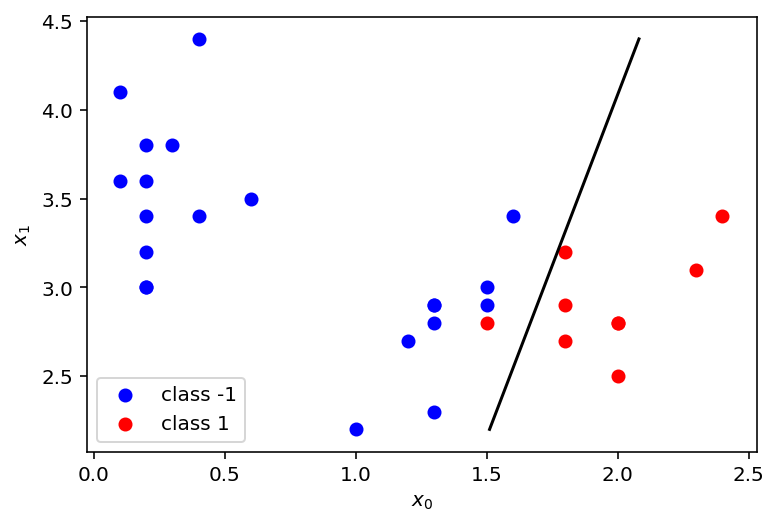

Test error: 0.03333333333333333


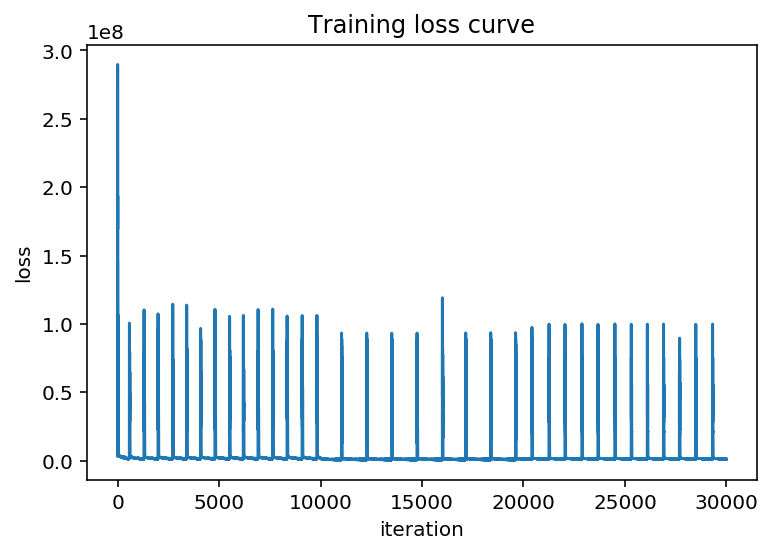

In [7]:
# Iris dataset. I'll be doing SVM. I'll be doing three trials/repeats of KNN,SVM
for i in range(3):
    iris = datasets.load_iris() # Load Iris dataset.

    X = iris.data               # The shape of X is (150, 4), which means
                                # there are 150 data points, each data point
                                # has 4 features.
    Y = (iris.target > 1.5).reshape(-1,1).astype(np.float) # The shape of Y is (150, 1), which means 
                                # there are 150 data points, each data point
                                # has 1 target value. 
    Y[Y==0] = -1

    X_and_Y = np.hstack((X, Y))     # Stack them together for shuffling.
                                    # NOTE: we don't set a seed.
    np.random.shuffle(X_and_Y)      # Shuffle the data points in X_and_Y array
    # Divide the data points into training set and test set.
    X_shuffled = X_and_Y[:,:4]
    Y_shuffled = X_and_Y[:,4]
    X_train = X_shuffled[:120][:, [3,1]]     # Shape: (120,2)
    Y_train = Y_shuffled[:120]               # Shape: (120,)
    X_test  = X_shuffled[120:][:, [3,1]]    # Shape: (30,2)
    Y_test  = Y_shuffled[120:]              # Shape: (30,)



# Training errors
    training_errors = np.zeros((len(C_list), len(gamma_list)))

    for i, C in enumerate(C_list):
        for j, gamma in enumerate(gamma_list):
        # Create a SVM classifier with RBF kernel.
            classifier = svm.SVC(kernel='rbf', C=C, gamma=gamma)

        # Use the classifier to fit the training set (use X_train, Y_train).
            classifier.fit(X_train, Y_train)

        # Show decision boundary, training error and test error.
            e_training = calc_error_htmap(X_train, Y_train, classifier)
            training_errors[i,j] = e_training
        
            if e_training < opt_e_training:
                opt_e_training = e_training
                opt_classifier = classifier
                opt_C          = C
                opt_gamma      = gamma
    draw_heatmap(training_errors, gamma_list, C_list)
    print('Best parameter C*={}, best parameter gamma*={}'.format(opt_C, opt_gamma))
    print('Test error: {}'.format(calc_error_htmap(X_test, Y_test, classifier)))
    print('Train error: {}'.format(calc_error_htmap(X_train, Y_train, classifier)))
    
    # Show decision boundary, training error and test error.
    for i in range(iterations):
    # Step 2. Compute the partial derivatives.
        grad_W, grad_b = grad_L_W_b(X_train, Y_train, W, b, C) 
    # Step 3. Update the parameters.
        W = W-(learning_rate*grad_W) 
        b = b-(learning_rate*grad_b)
    # Track the training losses.
        losses.append(L_W_b(X_train, Y_train, W, b, C))
    print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(W[0],W[1],b))
    vis(X_train, Y_train, W, b)
    print('Training error: {}'.format(calc_error(X_train, Y_train, W, b)))
    vis(X_test, Y_test, W, b)
    print('Test error: {}'.format(calc_error(X_test, Y_test, W, b)))
    # Plot training loss curve.
    plt.title('Training loss curve')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.plot(losses)
    plt.show()

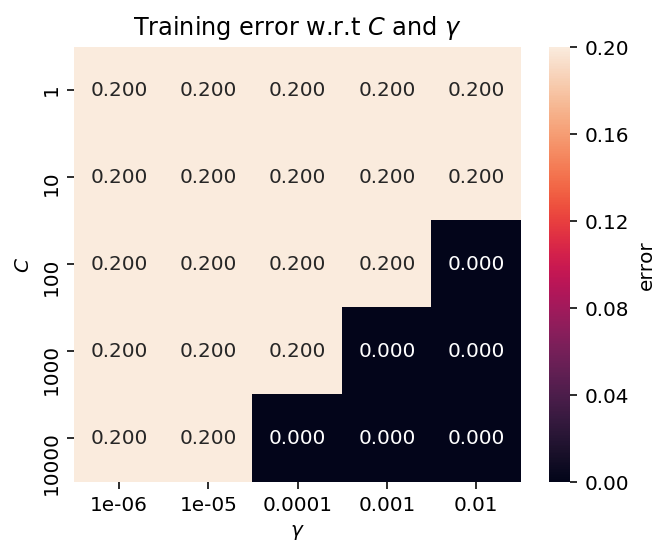

Best parameter C*=100, best parameter gamma*=0.01
Test error: 0.07499999999999996
Train error: 0.0
Decision boundary: 249.824x0+-64.774x1+-235.000=0


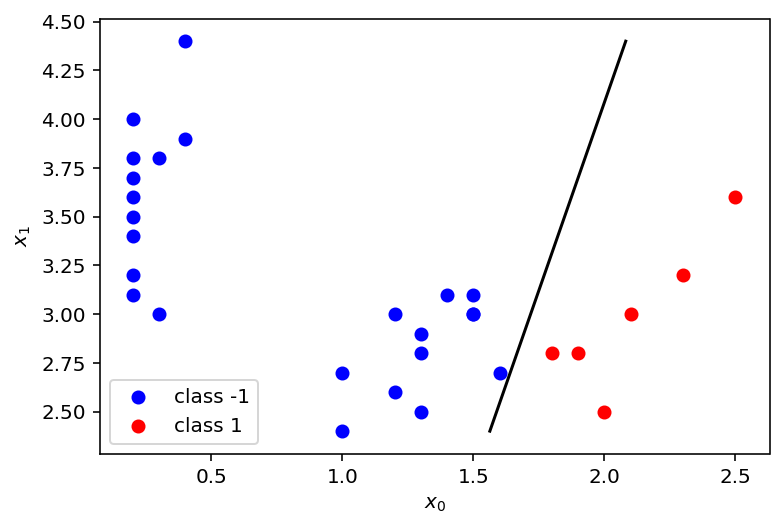

Training error: 0.0


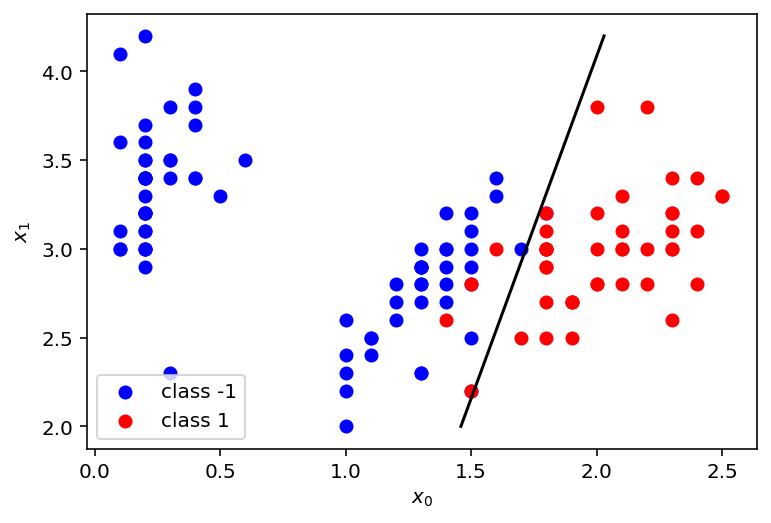

Test error: 0.041666666666666664


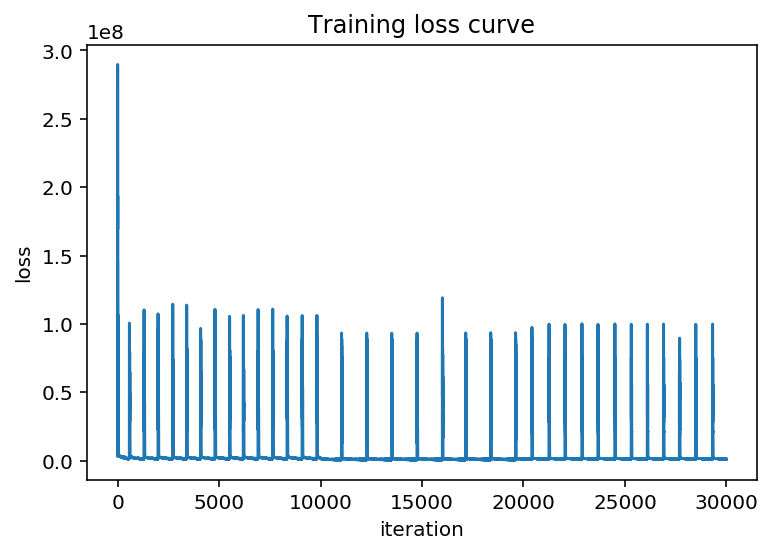

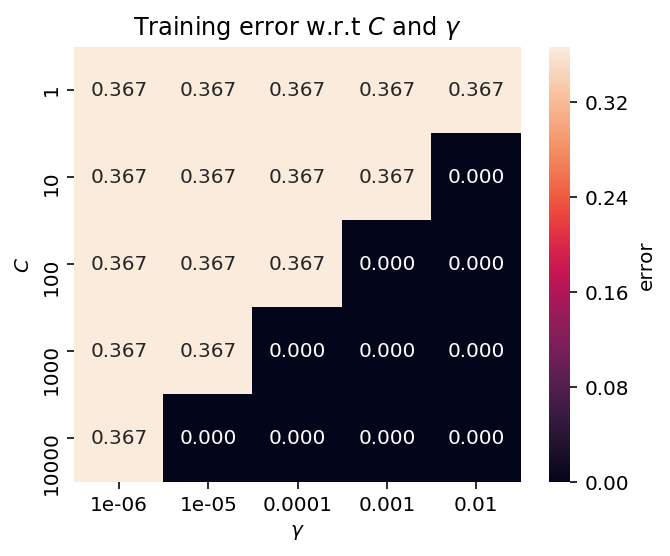

Best parameter C*=100, best parameter gamma*=0.01
Test error: 0.06666666666666665
Train error: 0.0
Decision boundary: 249.824x0+-64.774x1+-235.000=0


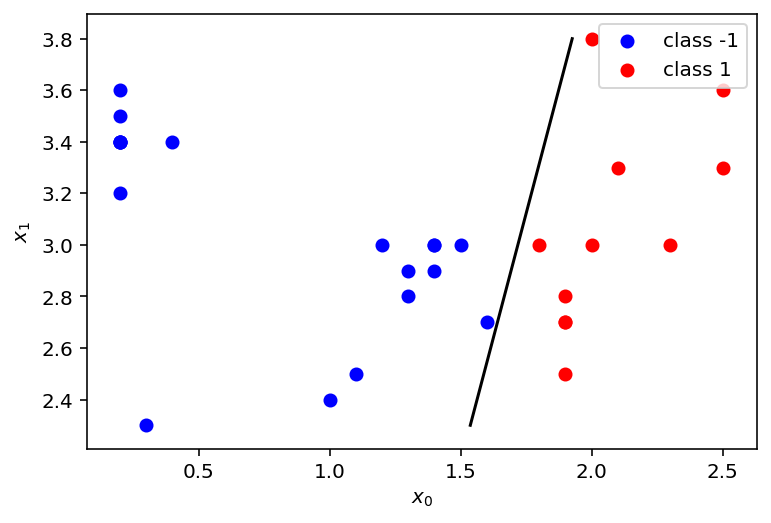

Training error: 0.0


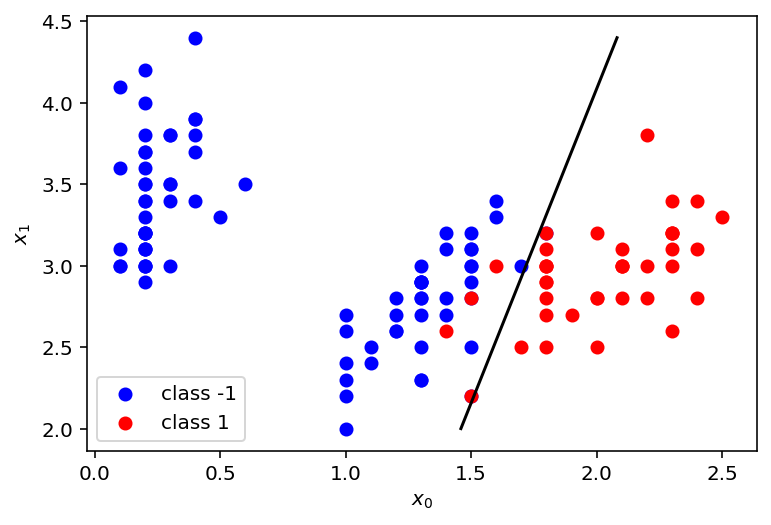

Test error: 0.041666666666666664


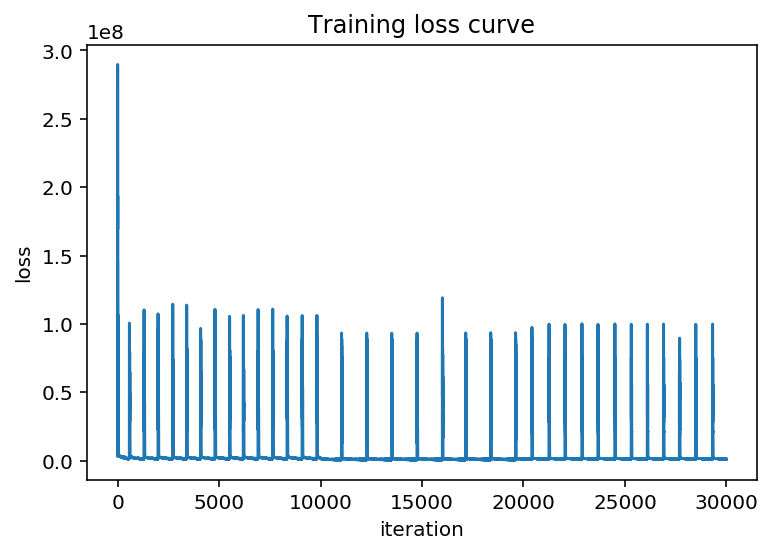

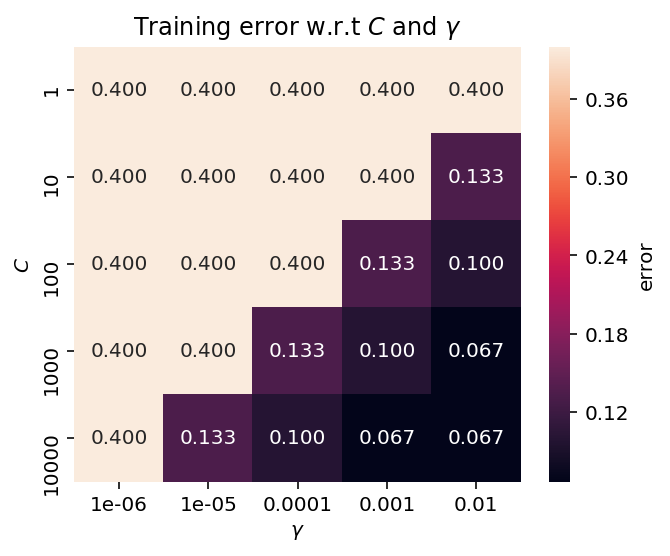

Best parameter C*=100, best parameter gamma*=0.01
Test error: 0.033333333333333326
Train error: 0.06666666666666665
Decision boundary: 249.824x0+-64.774x1+-235.000=0


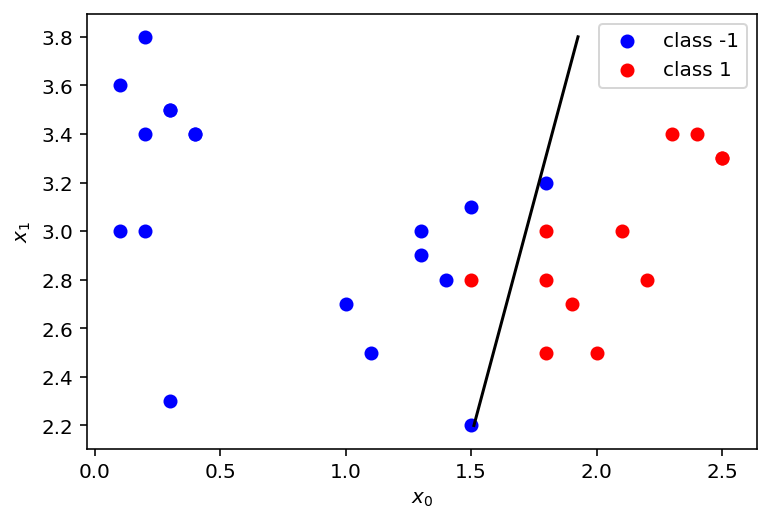

Training error: 0.06666666666666667


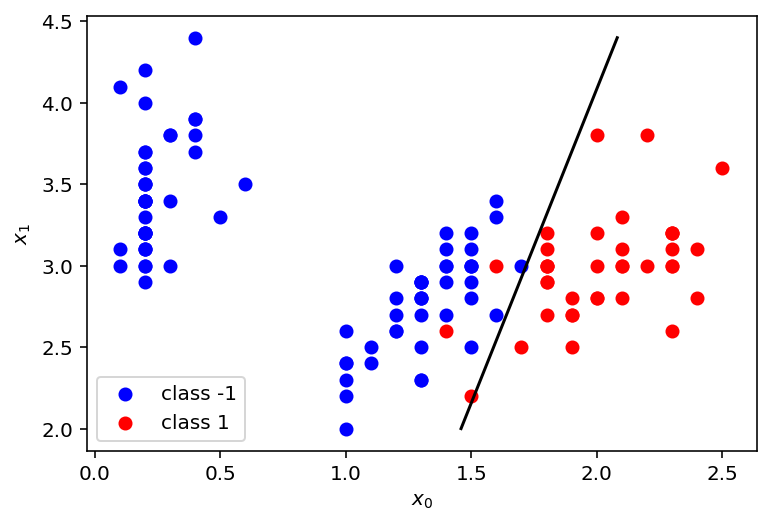

Test error: 0.025


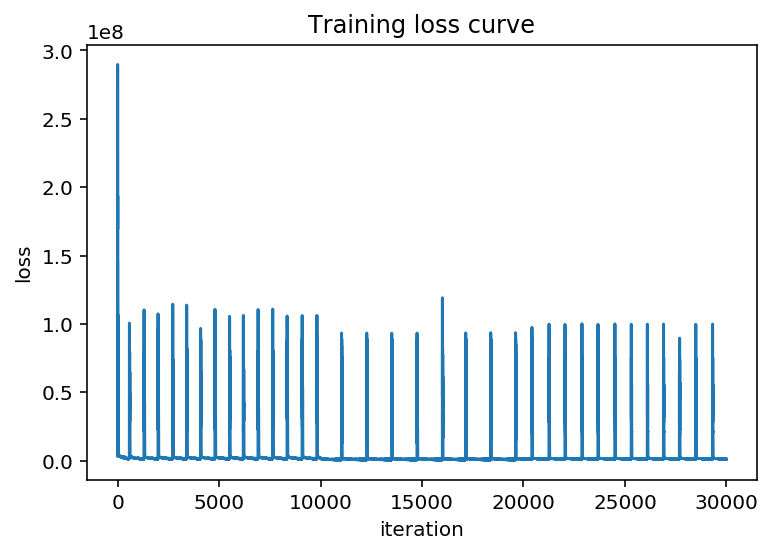

In [8]:
# Iris dataset. I'll be doing SVM. I'll be doing three trials/repeats of KNN,SVM
for i in range(3):
    iris = datasets.load_iris() # Load Iris dataset.

    X = iris.data               # The shape of X is (150, 4), which means
                                # there are 150 data points, each data point
                                # has 4 features.
    Y = (iris.target > 1.5).reshape(-1,1).astype(np.float) # The shape of Y is (150, 1), which means 
                                # there are 150 data points, each data point
                                # has 1 target value. 
    Y[Y==0] = -1

    X_and_Y = np.hstack((X, Y))     # Stack them together for shuffling.
                                    # NOTE: we don't set a seed.
    np.random.shuffle(X_and_Y)      # Shuffle the data points in X_and_Y array
    # Divide the data points into training set and test set.
    X_shuffled = X_and_Y[:,:4]
    Y_shuffled = X_and_Y[:,4]
    X_train = X_shuffled[:30][:, [3,1]]     # Shape: (30,2)
    Y_train = Y_shuffled[:30]               # Shape: (30,)
    X_test  = X_shuffled[30:][:, [3,1]]    # Shape: (120,2)
    Y_test  = Y_shuffled[30:]              # Shape: (120,)



# Training errors
    training_errors = np.zeros((len(C_list), len(gamma_list)))

    for i, C in enumerate(C_list):
        for j, gamma in enumerate(gamma_list):
        # Create a SVM classifier with RBF kernel.
            classifier = svm.SVC(kernel='rbf', C=C, gamma=gamma)

        # Use the classifier to fit the training set (use X_train, Y_train).
            classifier.fit(X_train, Y_train)

        # Show decision boundary, training error and test error.
            e_training = calc_error_htmap(X_train, Y_train, classifier)
            training_errors[i,j] = e_training
        
            if e_training < opt_e_training:
                opt_e_training = e_training
                opt_classifier = classifier
                opt_C          = C
                opt_gamma      = gamma
    draw_heatmap(training_errors, gamma_list, C_list)
    print('Best parameter C*={}, best parameter gamma*={}'.format(opt_C, opt_gamma))
    print('Test error: {}'.format(calc_error_htmap(X_test, Y_test, classifier)))
    print('Train error: {}'.format(calc_error_htmap(X_train, Y_train, classifier)))
    
    # Show decision boundary, training error and test error.
    print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(W[0],W[1],b))
    vis(X_train, Y_train, W, b)
    print('Training error: {}'.format(calc_error(X_train, Y_train, W, b)))
    vis(X_test, Y_test, W, b)
    print('Test error: {}'.format(calc_error(X_test, Y_test, W, b)))
    # Plot training loss curve.
    plt.title('Training loss curve')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.plot(losses)
    plt.show()


#### KNN

In [9]:
# Perform grid search for best number of nearest neighbors.

# 1. Create a k-NN classifier.
estimator = neighbors.KNeighborsClassifier()

# 2. Create a grid searcher with 5-fold cross-validation.
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
param_grid = {'n_neighbors': k_list}
grid_search = GridSearchCV(estimator, param_grid, cv=5)

# 3. Use the grid searcher to fit the training set.
grid_search.fit(X_train, Y_train)

# Draw heatmaps for result of grid search.
def draw_heatmap_knn(errors, D_list, title):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
    ax.collections[0].colorbar.set_label('error')
    ax.set(ylabel='k')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title(title)
    plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [10]:
#visualization for KNN
def vis(X, Y, knn_classifier=None):
    # Visualize k-NN.
    if knn_classifier is not None:
        # Calculate min, max and create grids.
        h = .02
        x0_min, x0_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        x1_min, x1_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
        x0s, x1s = np.meshgrid(np.arange(x0_min, x0_max, h),
                               np.arange(x1_min, x1_max, h))
        xs = np.stack([x0s, x1s], axis=-1).reshape(-1, 2)

        # Predict class using kNN classifier and data.
        ys_pred = np.array([knn_classifier(x) for x in xs])
        ys_pred = ys_pred.reshape(x0s.shape)

        # Put the result into a color plot.
        # Color map: #00AAFF - blue, #FFAAAA - red, #AAFFAA - green
        
        cmap_light = ListedColormap(['#00AAFF', '#FFAAAA'])
        plt.pcolormesh(x0s, x1s, ys_pred, cmap=cmap_light, alpha=0.3)
    
    indices_neg1 = (Y == -1).nonzero()[0]
    indices_pos1 = (Y == 1).nonzero()[0]
    plt.scatter(X[:,0][indices_neg1], X[:,1][indices_neg1], 
                c='blue', label='class -1', alpha=0.3)
    plt.scatter(X[:,0][indices_pos1], X[:,1][indices_pos1], 
                c='red', label='class +1', alpha=0.3)
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')

    plt.show()

In [11]:
# Euclidean distance.
def calc_distance(x1, x2):
    # x1, x2 are two NumPy vectors
    # Return the Euclidean distance between x1 and x2. It should be a scalar.
    n=len(x1)
    dist=0
    for i in range(n):
        dist = dist+ np.sqrt((x1[i]-x2[i])**2)######## To be filled. ########
    return dist
    
# k nearest neighbor predictor.
def f_knn(x, X_train, Y_train, k):
    # Create the list of (distance, label) pairs.
    dist_label_pairs = []
    for xi, yi in zip(X_train, Y_train):
        # Calculate the distance.
        dist = calc_distance(xi, x)
        # Add a (distance, label) pair to the list.
        dist_label_pairs.append((dist, yi))
    # Sort the pairs by distance (ascending).
    sorted_dist_label_pairs = sorted(dist_label_pairs, key=lambda x:x[0])
    # Obtain the first k pairs (corresponding to k smallest distances).
    k_dist_label_pairs = sorted_dist_label_pairs[:k] ######## To be filled. ########
    # Extract the labels of the k pairs.
    k_labels           = [y for x, y in k_dist_label_pairs]  ######## To be filled. ########
    # Count the number of +1 predictions and -1 predictions.
    pos1_in_k_labels = 0 
    neg1_in_k_labels = 0
    for label in k_labels:
        if label == +1:
            pos1_in_k_labels += 1
        elif label == -1:
            neg1_in_k_labels += 1
    # Make the prediction based on counts.
    if pos1_in_k_labels > neg1_in_k_labels:
        y_pred = +1
    else:
        y_pred = -1

    return y_pred
    
# Judge function: 1(a != b). It supports scalar, vector and matrix.
def judge(a, b):
    return np.array(a != b).astype(np.float32)

# Calculate error given feature vectors X and labels Y.
def calc_error(X, Y, knn_classifier):
    e = 0
    n = len(X)
    for (xi, yi) in zip(X, Y):
        e += judge(yi, knn_classifier(xi))
    e = 1.0 * e / n
    return e

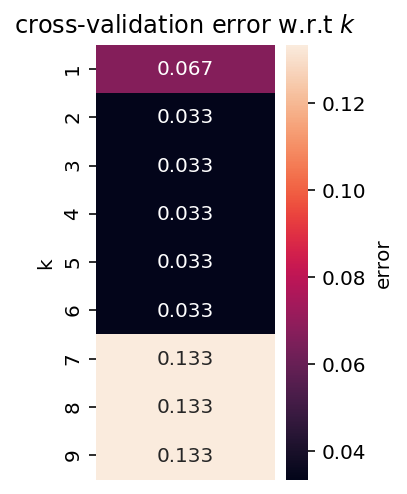

Best number of nearest neighbors (k): 2


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


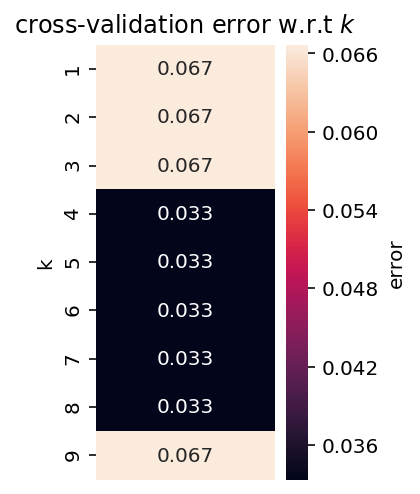

Best number of nearest neighbors (k): 4


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


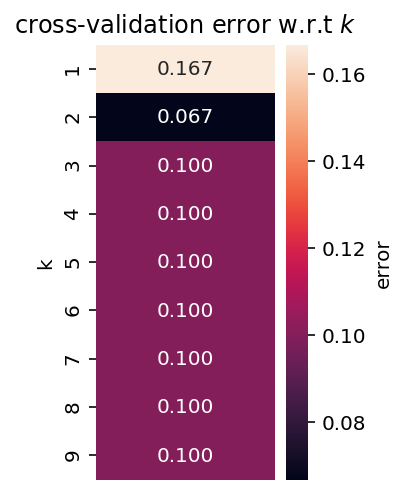

Best number of nearest neighbors (k): 2
k=1


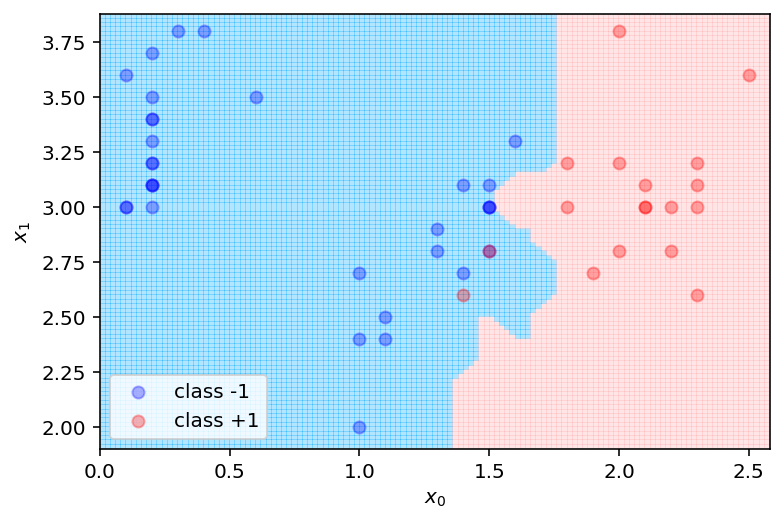

Validation error: 0.04

Best k=1


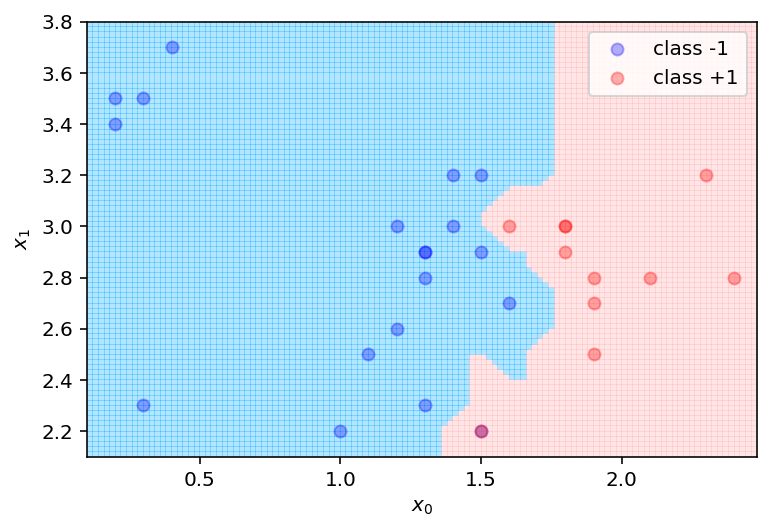

Train Error: 0.03333333333333333
Best k=1


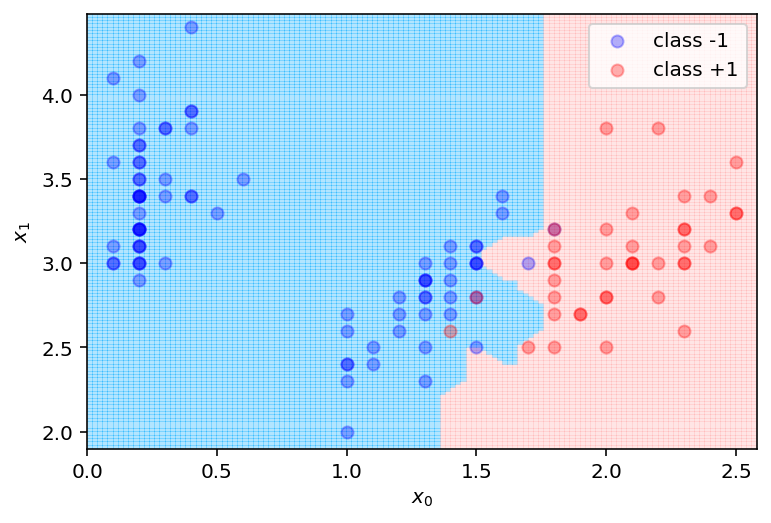

Test error: 0.041666666666666664
k=2


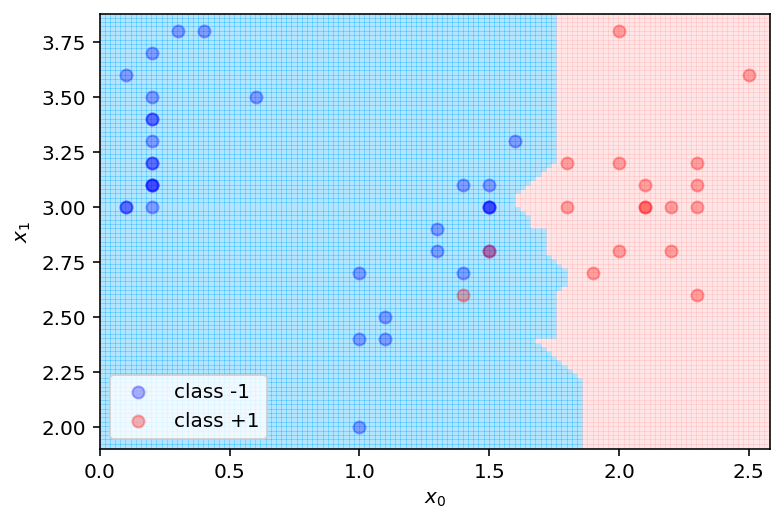

Validation error: 0.04

Best k=1


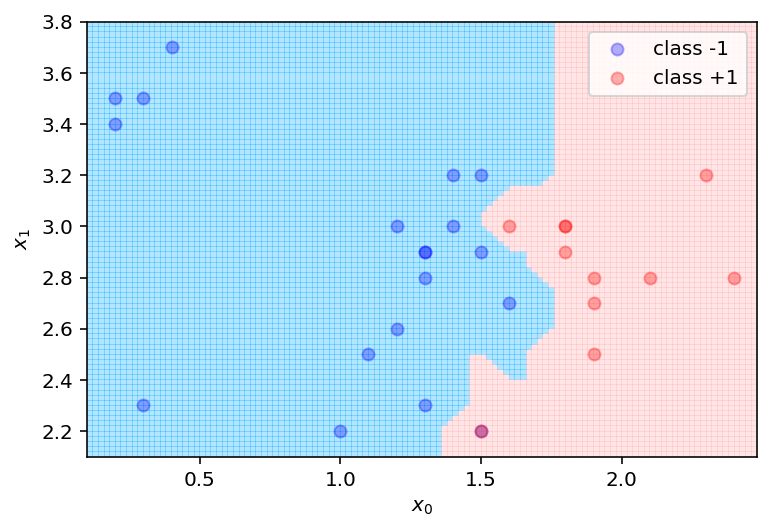

Train Error: 0.03333333333333333
Best k=1


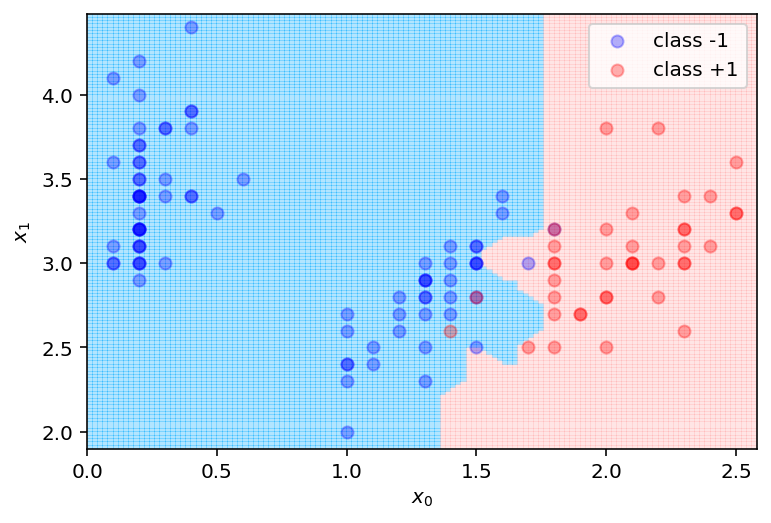

Test error: 0.041666666666666664
k=3


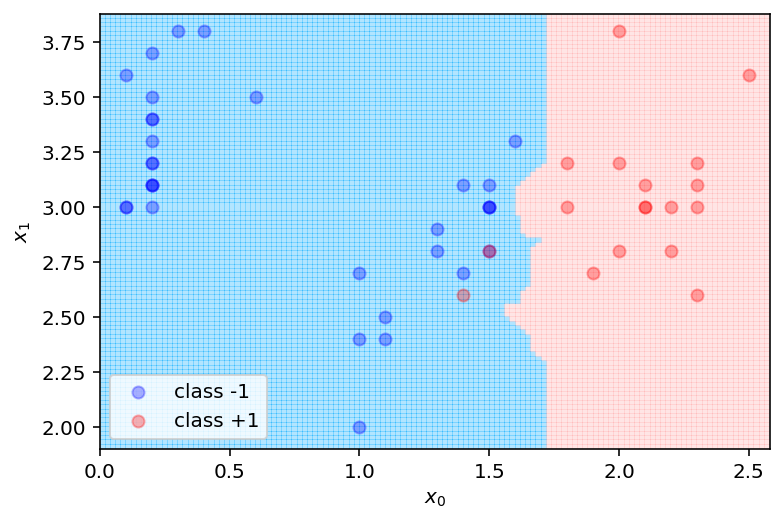

Validation error: 0.04

Best k=1


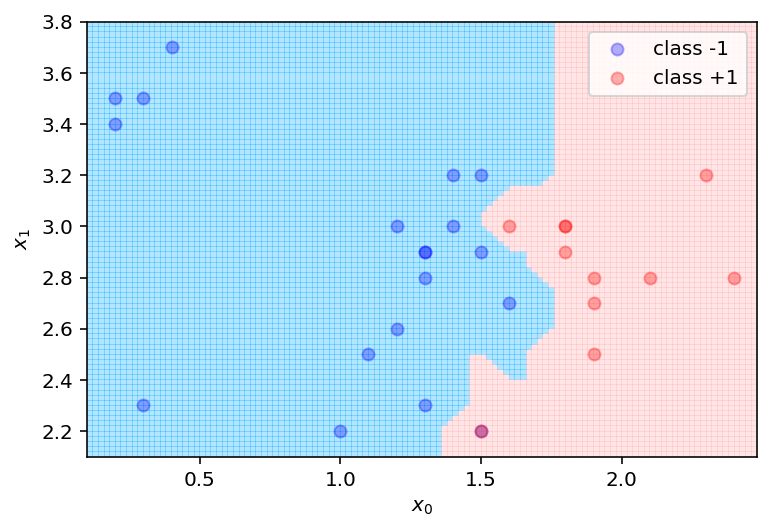

Train Error: 0.03333333333333333
Best k=1


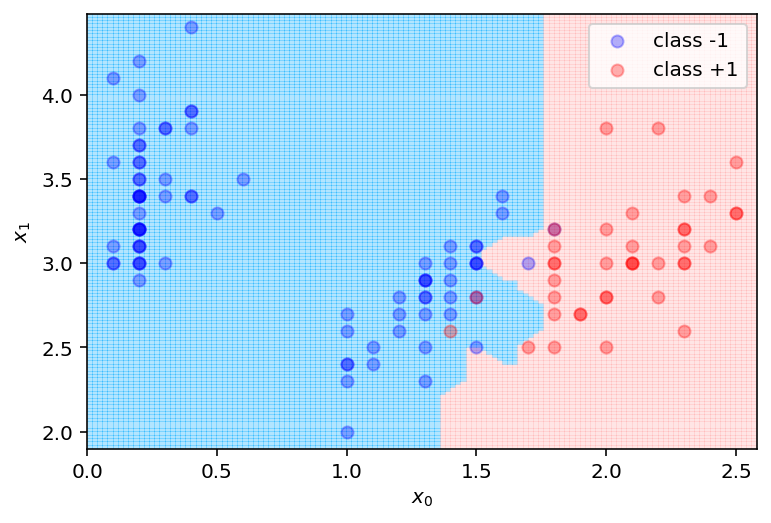

Test error: 0.041666666666666664


In [12]:
for i in range(3):
    iris = datasets.load_iris()     # Load Iris dataset.

    X = iris.data               # The shape of X is (150, 4), which means
                                # there are 150 data points, each data point
                                # has 4 features.
    Y = (iris.target > 1.5).reshape(-1,1).astype(np.float) # The shape of Y is (150, 1), which means 
                                # there are 150 data points, each data point
                                # has 1 target value. 
    Y[Y==0] = -1

    X_and_Y = np.hstack((X, Y))     # Stack them together for shuffling.
                                    # NOTE: we don't set a seed.
    np.random.shuffle(X_and_Y)      # Shuffle the data points in X_and_Y array
    # Divide the data points into training set and test set.
    X_shuffled = X_and_Y[:,:4]
    Y_shuffled = X_and_Y[:,4]
    X_val   = X_shuffled[50:100][:, [3,1]]  
    Y_val   = Y_shuffled[50:100]        
    X_train = X_shuffled[:30][:, [3,1]]    # Shape: (30,2)
    Y_train = Y_shuffled[:30]              # Shape: (30,)
    X_test  = X_shuffled[30:][:, [3,1]]    # Shape: (120,2)
    Y_test  = Y_shuffled[30:]              # Shape: (120,)
    
    
    # Perform grid search for best number of nearest neighbors.

    # 1. Create a k-NN classifier.
    estimator = neighbors.KNeighborsClassifier()

    # 2. Create a grid searcher with 5-fold cross-validation.
    k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    param_grid = {'n_neighbors': k_list}
    grid_search = GridSearchCV(estimator, param_grid, cv=5)

    # 3. Use the grid searcher to fit the training set.
    grid_search.fit(X_train, Y_train)
    cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
    draw_heatmap_knn(cross_val_errors, k_list, title='cross-validation error w.r.t $k$')
    # Show the best k.
    best_k = grid_search.best_params_['n_neighbors']
    print("Best number of nearest neighbors (k): {}".format(best_k))
    
    
opt_val_error = 1.0
opt_k = None

# Try different k(s).
for k in [1,2,3]:
    # Visualize 
    #   1. Validation set (as points).
    #   2. Decision boundary from training set (as background).
    print("k={}".format(k))
    # Create a k-NN classifier with training set.
    knn_classifier = partial(f_knn, X_train=X_train, Y_train=Y_train, k=k)
    # Visualization.
    vis(X_val, Y_val, knn_classifier)
    # Calculate validation error.
    val_error = calc_error(X_val, Y_val, knn_classifier)
    print("Validation error: {}\n".format(val_error))
    if val_error < opt_val_error:
        opt_val_error = val_error
        opt_k = k
        opt_knn_classifier = knn_classifier
    print("Best k={}".format(opt_k))
    train_error = calc_error(X_train, Y_train, opt_knn_classifier)
    vis(X_train, Y_train, opt_knn_classifier)
    print("Train Error: {}".format(train_error))
    print("Best k={}".format(opt_k))
    test_error = calc_error(X_test, Y_test, opt_knn_classifier)
    vis(X_test, Y_test, opt_knn_classifier)
    print("Test error: {}".format(test_error))


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


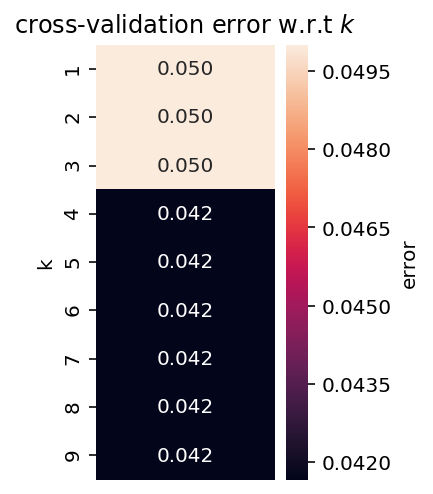

Best number of nearest neighbors (k): 4


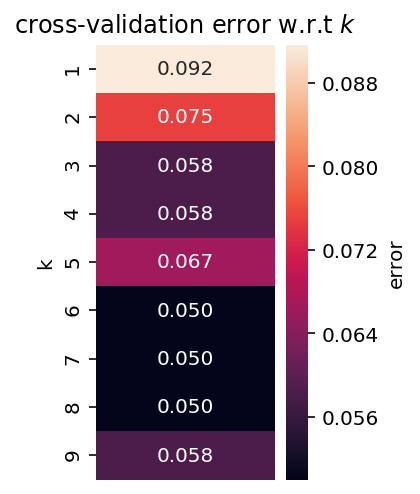

Best number of nearest neighbors (k): 6


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


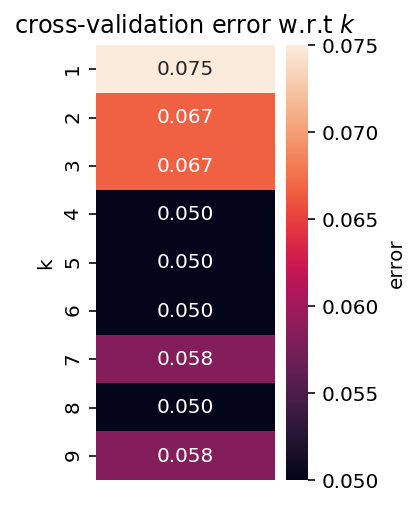

Best number of nearest neighbors (k): 4
k=1


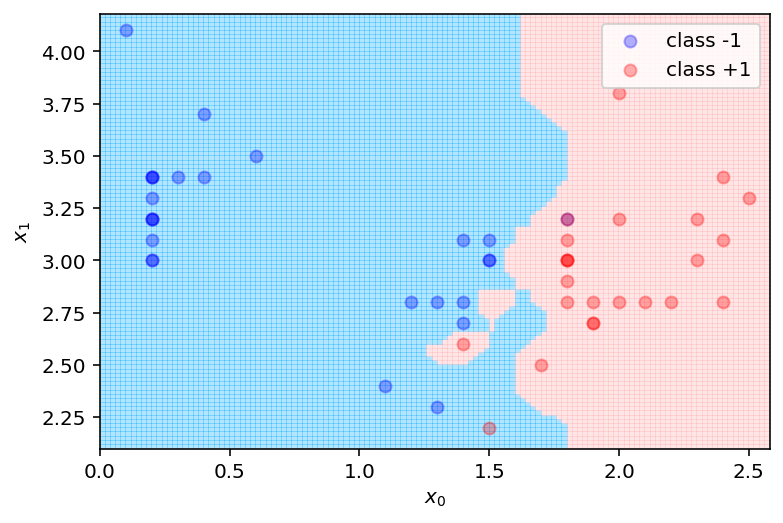

Validation error: 0.04

Best k=1


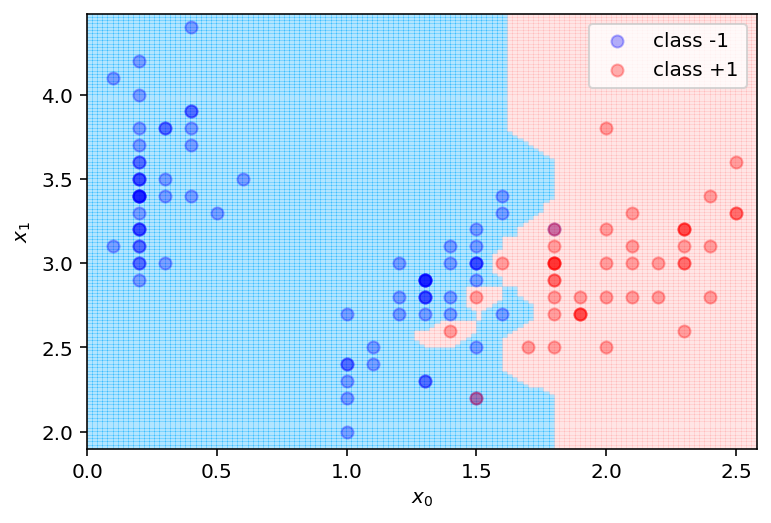

Train error: 0.041666666666666664
Best k=1


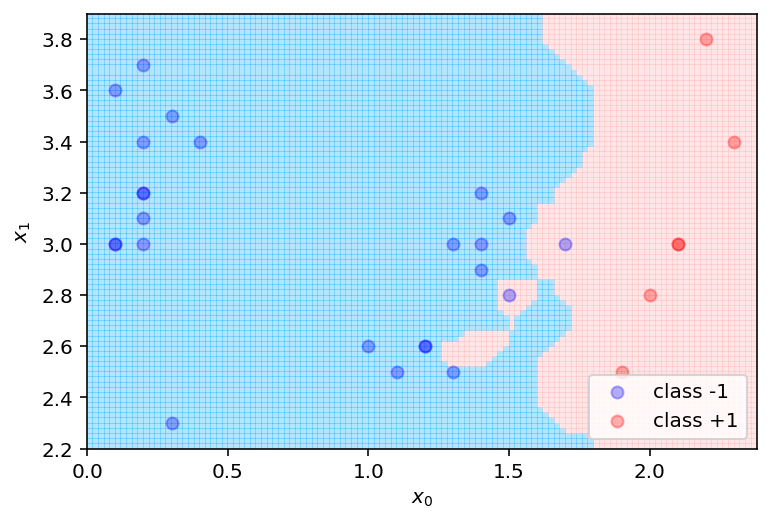

Test error: 0.06666666666666667
k=2


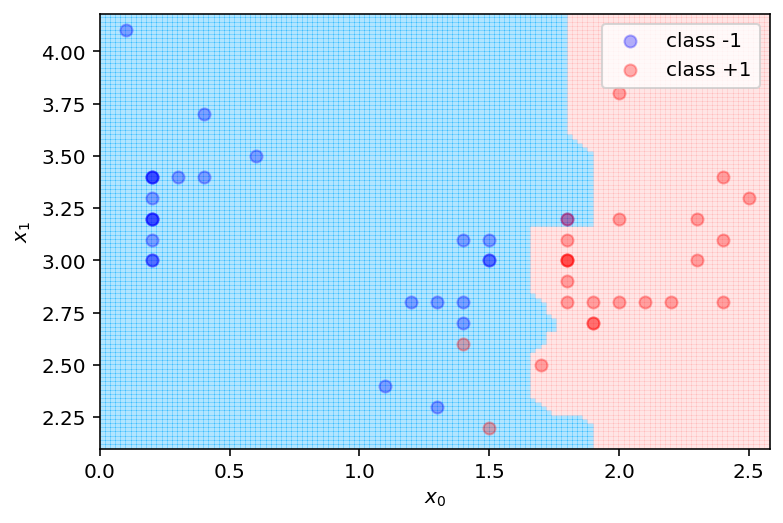

Validation error: 0.06

Best k=1


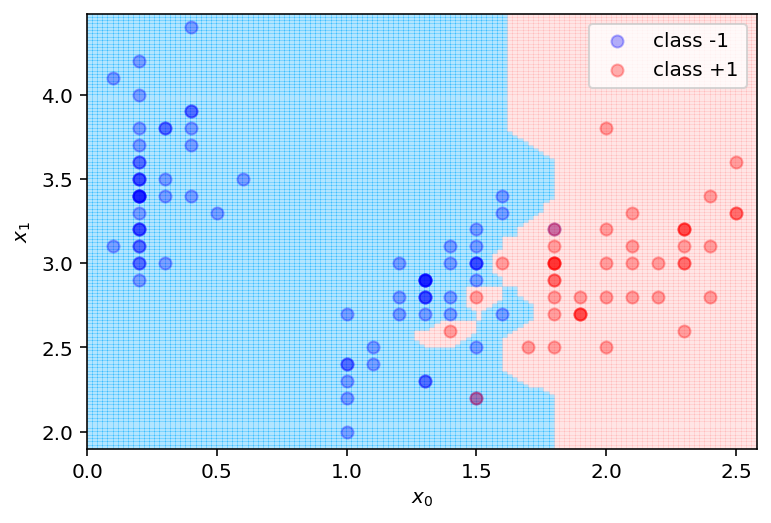

Train error: 0.06666666666666667
Best k=1


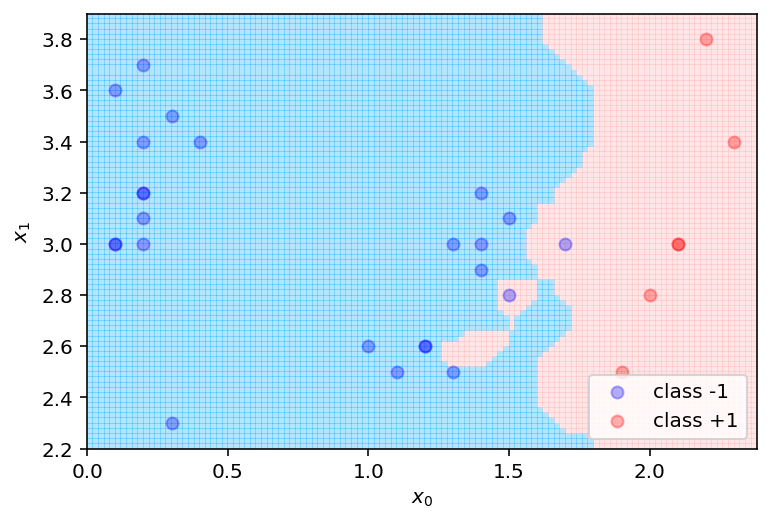

Test error: 0.06666666666666667
k=3


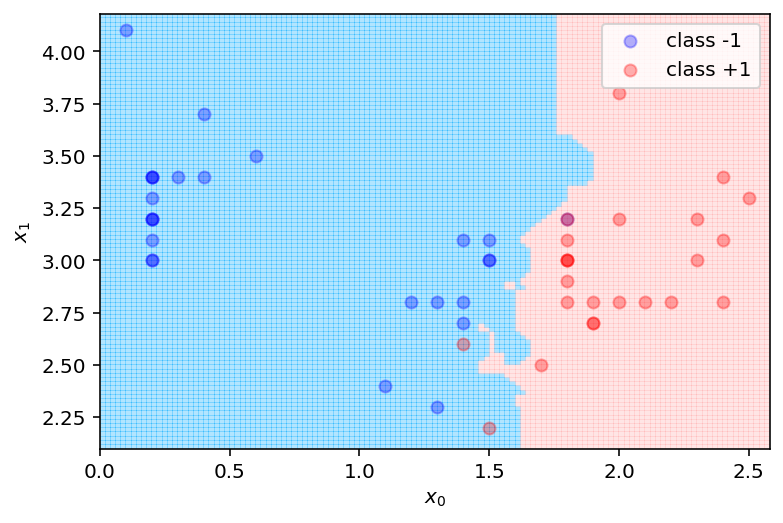

Validation error: 0.06

Best k=1


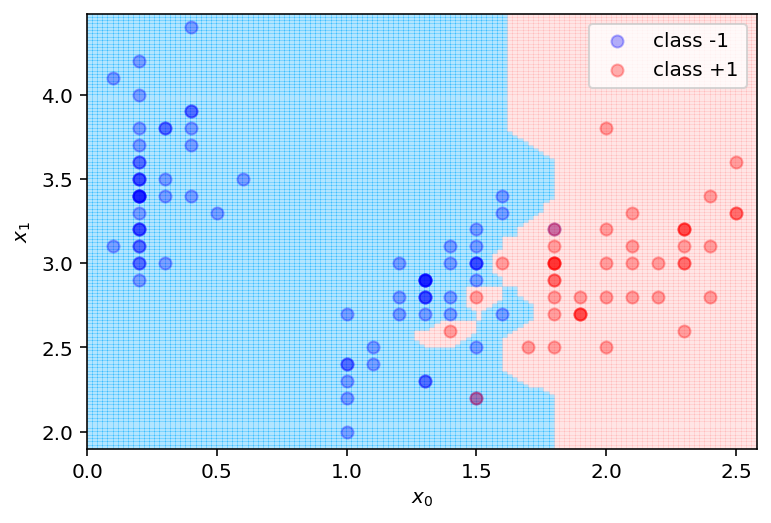

Train error: 0.06666666666666667
Best k=1


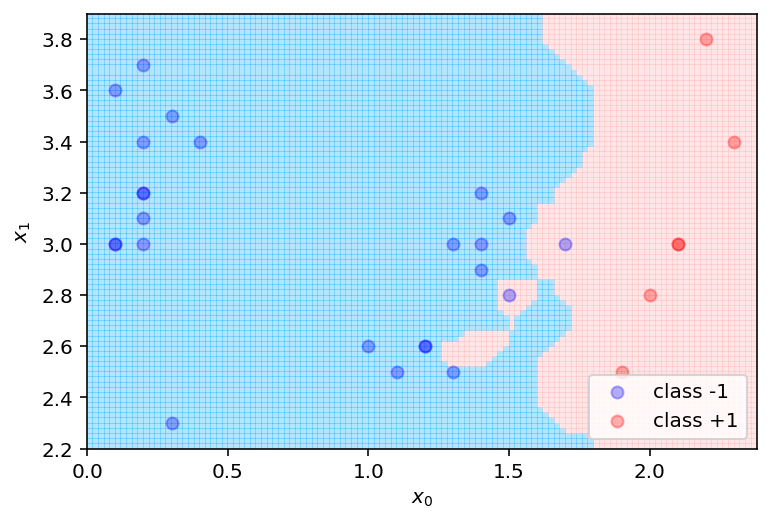

Test error: 0.06666666666666667


In [13]:
for i in range(3):
    iris = datasets.load_iris()     # Load Iris dataset.

    X = iris.data               # The shape of X is (150, 4), which means
                                # there are 150 data points, each data point
                                # has 4 features.
    Y = (iris.target > 1.5).reshape(-1,1).astype(np.float) # The shape of Y is (150, 1), which means 
                                # there are 150 data points, each data point
                                # has 1 target value. 
    Y[Y==0] = -1

    X_and_Y = np.hstack((X, Y))     # Stack them together for shuffling.
                                    # NOTE: we don't set a seed.
    np.random.shuffle(X_and_Y)      # Shuffle the data points in X_and_Y array
    # Divide the data points into training set and test set.
    X_shuffled = X_and_Y[:,:4]
    Y_shuffled = X_and_Y[:,4]
    X_val   = X_shuffled[50:100][:, [3,1]]  
    Y_val   = Y_shuffled[50:100]            
    X_train = X_shuffled[:120][:, [3,1]]     # Shape: (120,2)
    Y_train = Y_shuffled[:120]               # Shape: (120,)
    X_test  = X_shuffled[120:][:, [3,1]]    # Shape: (30,2)
    Y_test  = Y_shuffled[120:]              # Shape: (30,)
    
    
    # Perform grid search for best number of nearest neighbors.

    # 1. Create a k-NN classifier.
    estimator = neighbors.KNeighborsClassifier()

    # 2. Create a grid searcher with 5-fold cross-validation.
    k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    param_grid = {'n_neighbors': k_list}
    grid_search = GridSearchCV(estimator, param_grid, cv=5)

    # 3. Use the grid searcher to fit the training set.
    grid_search.fit(X_train, Y_train)
    cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
    draw_heatmap_knn(cross_val_errors, k_list, title='cross-validation error w.r.t $k$')
    # Show the best k.
    best_k = grid_search.best_params_['n_neighbors']
    print("Best number of nearest neighbors (k): {}".format(best_k))
    
    
opt_val_error = 1.0
opt_k = None

# Try different k(s).
for k in [1,2,3]:
    # Visualize 
    #   1. Validation set (as points).
    #   2. Decision boundary from training set (as background).
    print("k={}".format(k))
    # Create a k-NN classifier with training set.
    knn_classifier = partial(f_knn, X_train=X_train, Y_train=Y_train, k=k)
    # Visualization.
    vis(X_val, Y_val, knn_classifier)
    # Calculate validation error.
    val_error = calc_error(X_val, Y_val, knn_classifier)
    print("Validation error: {}\n".format(val_error))
    if val_error < opt_val_error:
        opt_val_error = val_error
        opt_k = k
        opt_knn_classifier = knn_classifier
    print("Best k={}".format(opt_k))
    train_error = calc_error(X_train, Y_train, opt_knn_classifier)
    vis(X_train, Y_train, opt_knn_classifier)
    print("Train error: {}".format(test_error))
    print("Best k={}".format(opt_k))
    test_error = calc_error(X_test, Y_test, opt_knn_classifier)
    vis(X_test, Y_test, opt_knn_classifier)
    print("Test error: {}".format(test_error))


### Decision tree

In [14]:
# Draw heatmaps for result of grid search.
def draw_heatmap(errors, D_list, title):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
    ax.collections[0].colorbar.set_label('error')
    ax.set(ylabel='max depth D')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title(title)
    plt.show()


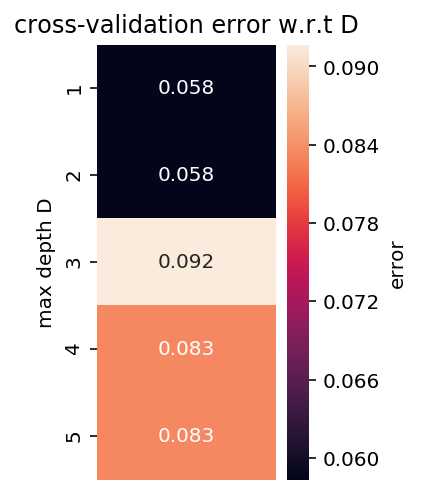

Best max depth D: 1
Train error: 0.04166666666666663
Test error: 0.09999999999999998


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


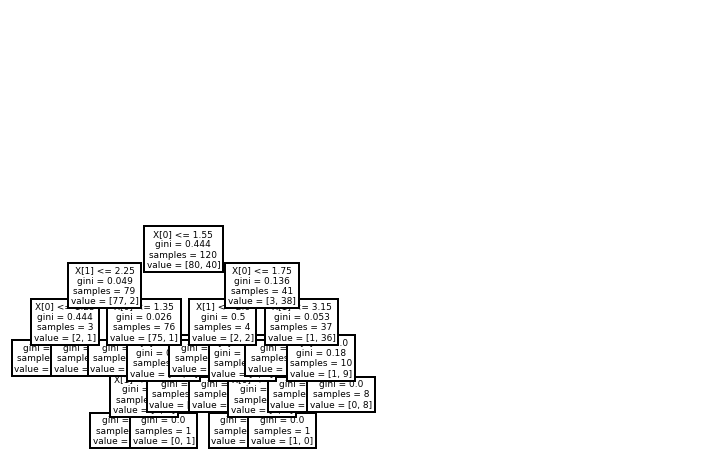

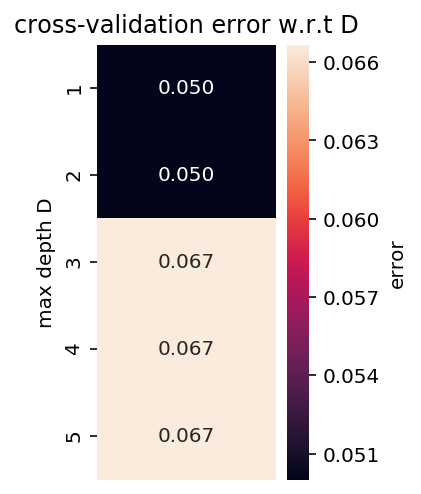

Best max depth D: 1
Train error: 0.04166666666666663
Test error: 0.09999999999999998


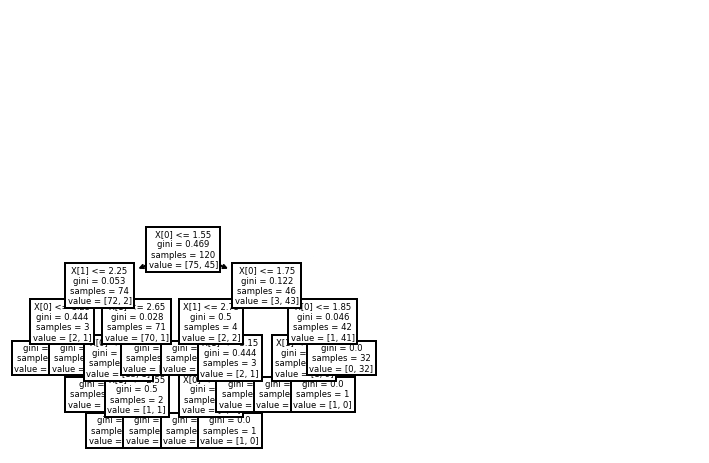

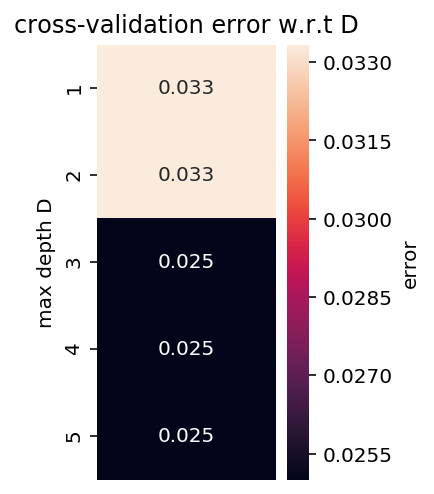

Best max depth D: 3
Train error: 0.01666666666666672
Test error: 0.1333333333333333


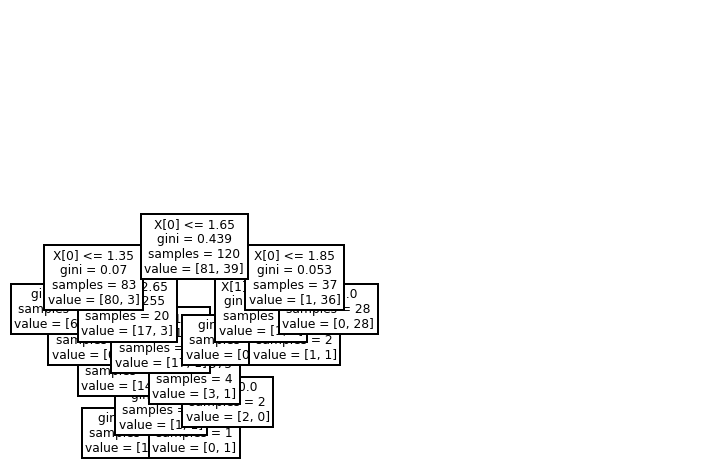

In [15]:
for i in range(3):
    iris = datasets.load_iris() # Load Iris dataset.

    X = iris.data               # The shape of X is (150, 4), which means
                                # there are 150 data points, each data point
                                # has 4 features.
    Y = (iris.target > 1.5).reshape(-1,1).astype(np.float) # The shape of Y is (150, 1), which means 
                                # there are 150 data points, each data point
                                # has 1 target value. 
    Y[Y==0] = -1

    X_and_Y = np.hstack((X, Y))     # Stack them together for shuffling.
                                    # NOTE: we don't set a seed.
    np.random.shuffle(X_and_Y)      # Shuffle the data points in X_and_Y array
    # Divide the data points into training set and test set.
    X_shuffled = X_and_Y[:,:4]
    Y_shuffled = X_and_Y[:,4]
    X_train = X_shuffled[:120][:, [3,1]]     # Shape: (120,2)
    Y_train = Y_shuffled[:120]               # Shape: (120,)
    X_test  = X_shuffled[120:][:, [3,1]]    # Shape: (30,2)
    Y_test  = Y_shuffled[120:]              # Shape: (30,)
    # Perform grid search for best max depth.

    # 1. Create a decision tree classifier.
    #    Hint: You can use tree.DecisionTreeClassifier()
    #          We use "entropy" as the criterion. The random state should be
    #          set to 1 for consistent results. Other options are left at default.
    estimator = tree.DecisionTreeClassifier(criterion='entropy', random_state=1)
    # 2. Create a grid searcher with cross-validation.
    D_list = [1, 2, 3, 4, 5]
    param_grid = {'max_depth': D_list}
    #    Hint: You can use GridSearchCV()
    #          Please set a 10-fold cross-validation.
    grid_search = GridSearchCV(estimator, param_grid, cv=10)
    # 3. Use the grid searcher to fit the training set.
    #    - This grid searcher will try every max depth in the list. 
    #    - For each max depth, a cross-validation is applied to the training set, 
    #      that is, it creates several (training subset, validation subset) pairs. 
    #      Note: Sometimes the validation subset is called as "test" subset, but it
    #            is not the subset of real test set.
    #        - For each pair, a decision tree classifier will be trained on the 
    #          training subset and evaluated on validation subset.
    #        - The average validation scores will be kept.
    #    
    #    Hint: You can simply use .fit() function of the grid searcher.
    grid_search.fit(X_train, Y_train)
    
    cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
    draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
    best_max_depth = grid_search.best_params_['max_depth']
    print("Best max depth D: {}".format(best_max_depth))
    
    #Train error
    train_error = 1 - sum(grid_search.best_estimator_.predict(X_train) == Y_train) / len(X_train)
    print("Train error: {}".format(train_error))
    # Calculate the test error.
    test_error = 1 - sum(grid_search.best_estimator_.predict(X_test) == Y_test) / len(X_test)
    print("Test error: {}".format(test_error))
   
    
    clf = tree.DecisionTreeClassifier(random_state=0)
    clf = clf.fit(X_train, Y_train)
    tree.plot_tree(clf) 



/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


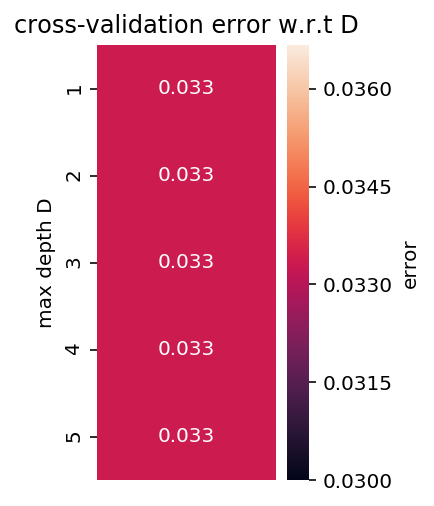

Best max depth D: 1
Train error: 0.033333333333333326
Test error: 0.04166666666666663


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


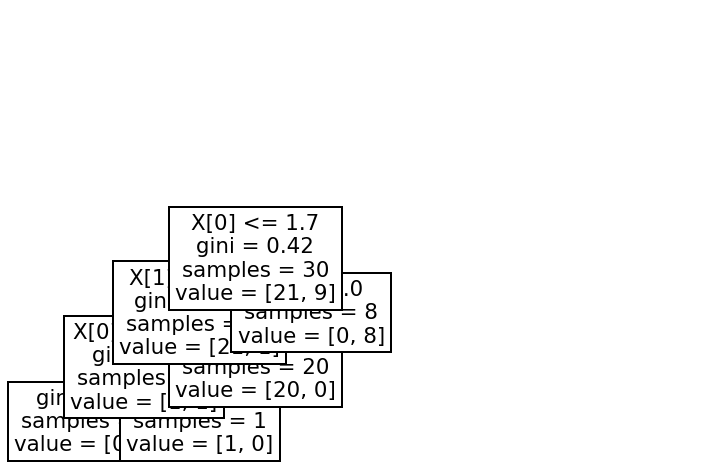

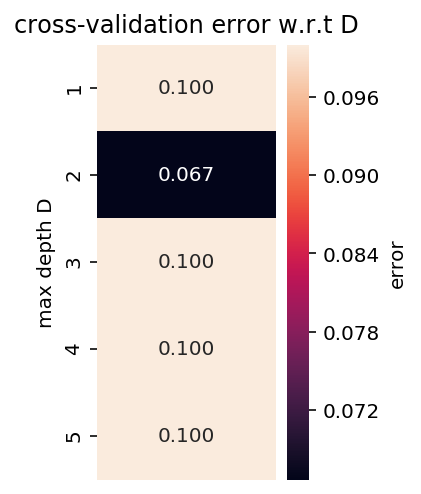

Best max depth D: 2
Train error: 0.033333333333333326
Test error: 0.04166666666666663


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


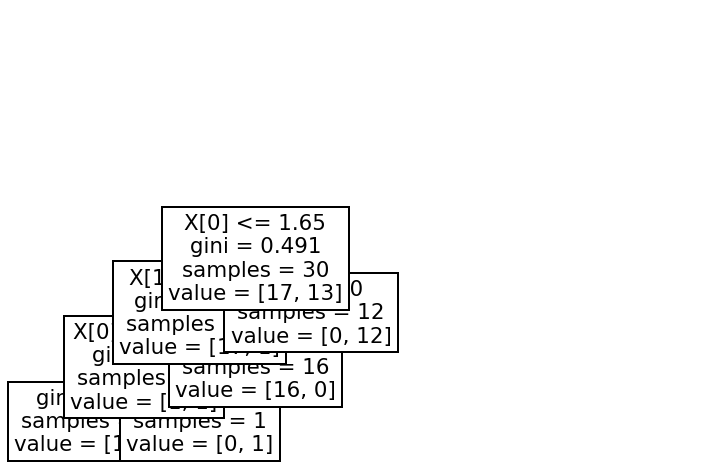

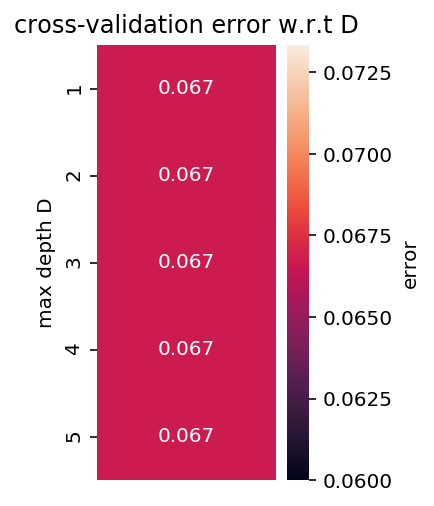

Best max depth D: 1
Train error: 0.033333333333333326
Test error: 0.05833333333333335


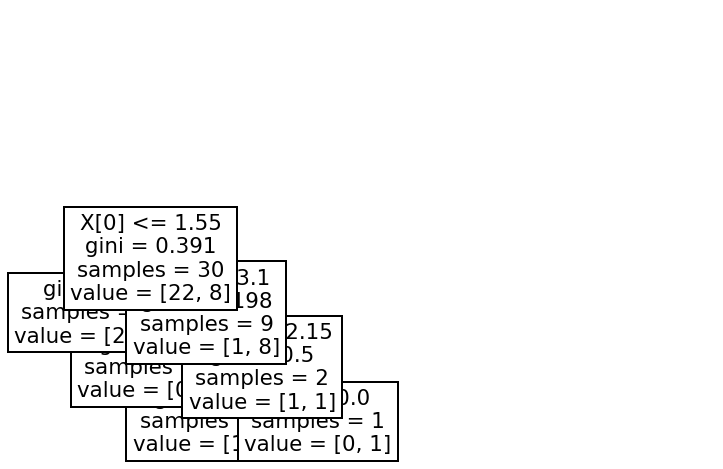

In [16]:
for i in range(3):
    iris = datasets.load_iris() # Load Iris dataset.

    X = iris.data               # The shape of X is (150, 4), which means
                                # there are 150 data points, each data point
                                # has 4 features.
    Y = (iris.target > 1.5).reshape(-1,1).astype(np.float) # The shape of Y is (150, 1), which means 
                                # there are 150 data points, each data point
                                # has 1 target value. 
    Y[Y==0] = -1

    X_and_Y = np.hstack((X, Y))     # Stack them together for shuffling.
                                    # NOTE: we don't set a seed.
    np.random.shuffle(X_and_Y)      # Shuffle the data points in X_and_Y array
    # Divide the data points into training set and test set.
    X_shuffled = X_and_Y[:,:4]
    Y_shuffled = X_and_Y[:,4]
    X_train = X_shuffled[:30][:, [3,1]]     # Shape: (30,2)
    Y_train = Y_shuffled[:30]               # Shape: (30,)
    X_test  = X_shuffled[30:][:, [3,1]]    # Shape: (120,2)
    Y_test  = Y_shuffled[30:]              # Shape: (120,)
    # Perform grid search for best max depth.

    # 1. Create a decision tree classifier.
    #    Hint: You can use tree.DecisionTreeClassifier()
    #          We use "entropy" as the criterion. The random state should be
    #          set to 1 for consistent results. Other options are left at default.
    estimator = tree.DecisionTreeClassifier(criterion='entropy', random_state=1)
    # 2. Create a grid searcher with cross-validation.
    D_list = [1, 2, 3, 4, 5]
    param_grid = {'max_depth': D_list}
    #    Hint: You can use GridSearchCV()
    #          Please set a 10-fold cross-validation.
    grid_search = GridSearchCV(estimator, param_grid, cv=10)
    # 3. Use the grid searcher to fit the training set.
    #    - This grid searcher will try every max depth in the list. 
    #    - For each max depth, a cross-validation is applied to the training set, 
    #      that is, it creates several (training subset, validation subset) pairs. 
    #      Note: Sometimes the validation subset is called as "test" subset, but it
    #            is not the subset of real test set.
    #        - For each pair, a decision tree classifier will be trained on the 
    #          training subset and evaluated on validation subset.
    #        - The average validation scores will be kept.
    #    
    #    Hint: You can simply use .fit() function of the grid searcher.
    grid_search.fit(X_train, Y_train)
    
    cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
    draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
    best_max_depth = grid_search.best_params_['max_depth']
    print("Best max depth D: {}".format(best_max_depth))
    #Train error
    train_error = 1 - sum(grid_search.best_estimator_.predict(X_train) == Y_train) / len(X_train)
    print("Train error: {}".format(train_error))
    # Calculate the test error.
    test_error = 1 - sum(grid_search.best_estimator_.predict(X_test) == Y_test) / len(X_test)
    print("Test error: {}".format(test_error))
   
    
    
    clf = tree.DecisionTreeClassifier(random_state=0)
    clf = clf.fit(X_train, Y_train)
    tree.plot_tree(clf) 

